# This notebook examines state-specific trends in the processed general.txt file (general.pkl)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import os
import re
import cpi

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')

# Agency prefix dictionary:
with open(processed_path + 'agency_dict.pkl', 'rb') as f_r:
    agency_dict = pickle.load(f_r)
# Entity code dictionary:
with open(processed_path + 'entity_dict.pkl', 'rb') as f_r:
    entity_dict = pickle.load(f_r)

Fields carried over from processing general.txt

In [2]:
# for i in df_general.columns:
#     print(i)

Adjust `DOLLARTHRESHOLD` and `TOTFEDEXPEND_ADJUSTED` for inflation

In [3]:
df_general['DOLLARTHRESHOLD_ADJUSTED'] = df_general.apply(lambda x: cpi.inflate(x.DOLLARTHRESHOLD, x.AUDITYEAR), axis=1)
df_general['TOTFEDEXPEND_ADJUSTED'] = df_general.apply(lambda x: cpi.inflate(x.TOTFEDEXPEND, x.AUDITYEAR), axis=1)

In [4]:
# Remove territories/islands
df_analysis = df_general[~df_general['STATE'].isin(['AS','MP','FM','PR','GU','PW','MH','VI'])]

## Calculate relative numbers of audits and total expenditure

In [25]:
series_state_pct_audits = 100 * df_analysis.groupby('STATE').size().sort_values(ascending=False) / len(df_analysis)
series_dict = {'PCT_ALL_AUDITS': series_state_pct_audits}
series_state_pct_fedexpend = 100 * df_analysis.groupby('STATE')\
    ['TOTFEDEXPEND_ADJUSTED'].sum().sort_values(ascending=False) / \
    df_analysis['TOTFEDEXPEND_ADJUSTED'].sum() 
series_dict['PCT_FEDEXPEND'] = series_state_pct_fedexpend

## Risk

In [26]:
df_risk_state = df_analysis.groupby('STATE')['LOWRISK'].value_counts().sort_index().unstack()
series_risk_state_norm = 100 * df_risk_state['N'] / len(df_analysis[df_analysis['LOWRISK'] == 'N'])
series_dict['PCT_HIGH_RISK'] = series_risk_state_norm

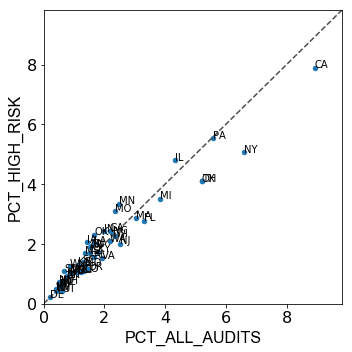

In [28]:
series1 = 'PCT_ALL_AUDITS'
series2 = 'PCT_HIGH_RISK'

fig, axes = plt.subplots(figsize=(5, 5))
df_plot = pd.concat(
    [series_dict[series1].rename(series1), series_dict[series2].rename(series2)], 
    axis=1, sort=True
)
axes_max = max(max(series_dict[series1]), max(series_dict[series2]))
df_plot.dropna(inplace=True)
plot = df_plot.plot(
    x=series1, y=series2, kind='scatter', fontsize=16, ax=axes
)
for i, point in df_plot.iterrows():
    axes.text(point[series1], point[series2], str(i))
plot.set_xlabel(series1, fontsize=16, fontname='Arial')
plot.set_ylabel(series2, fontsize=16, fontname='Arial')
plot.set_ylim(bottom=0, top=1.1*axes_max)
plot.set_xlim(left=0, right=1.1*axes_max)
axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3")

plt.tight_layout()
plt.show()

## Financial statements

What are the possible bases of accounting that can be used?

In [8]:
set(df_analysis['SP_FRAMEWORK'])

{'', 'CASH', 'CONTRACTUAL', 'OTHER', 'REGULATORY', 'TAX'}

Filter data based on a particular basis of accounting framework

In [9]:
framework = ''
df_financial = df_analysis[df_analysis['SP_FRAMEWORK'] == framework]
if framework != '':
    print('Number of audits prepared according to a %s special framework: %s' %(framework, len(df_financial)))

Filter by whether special framework was required by state law (only for special purpose frameworks)

In [10]:
# if framework != '':
#     df_financial = df_financial[df_financial['SP_FRAMEWORK_REQUIRED'] == 'Y']

Note that after both filtering steps, the following plots will contain information along the lines of: "California accounts for X% of all audits prepared according to GAAP, but accounts for Y% of all audits prepared according to GAAP with at least one material noncompliance."

In [41]:
fs_series_dict = {}
df_analysis_framework = df_analysis[df_analysis['SP_FRAMEWORK'] == framework]
###############################################################################
# Calculate general numbers: percent of all audits and total expenditure
###############################################################################
series_state_pct_audits = 100 * \
    df_financial.groupby('STATE').size() / \
    len(df_analysis_framework)
if framework == '':
    key_framework = 'GAAP'
else:
    key_framework = framework
fs_series_dict['PCT_%s_FRAMEWORK' %key_framework] = series_state_pct_audits
series_state_pct_fedexpend = 100 * \
    df_financial.groupby('STATE')['TOTFEDEXPEND_ADJUSTED'].sum() / \
    df_analysis_framework['TOTFEDEXPEND_ADJUSTED'].sum()
fs_series_dict['PCT_FEDEXPEND'] = series_state_pct_fedexpend
###############################################################################

###############################################################################
# Get percent of A/D audit opinions on financial statement preparation and 
# financial issues
###############################################################################
if framework == '':
    sortby_fs = 'TYPEREPORT_FS'
else:
    sortby_fs = 'TYPEREPORT_SP_FRAMEWORK'
ad_op_list = [
    i for i in set(df_financial[sortby_fs]) 
    if ('A' in i) or ('D' in i)
]
df_state_fs = df_financial.groupby('STATE')\
    [sortby_fs].value_counts().unstack()
series_state_ad_fs_norm = 100 * \
               df_state_fs[ad_op_list].sum(axis=1) / \
               len(df_analysis_framework[df_analysis_framework[sortby_fs].isin(ad_op_list)])
fs_series_dict[
    'PCT_AD_%s' %sortby_fs
] = series_state_ad_fs_norm

# Get percent of financial issues
for sortby_fs in [
    'GOINGCONCERN','REPORTABLECONDITION', 'MATERIALWEAKNESS',
    'MATERIALNONCOMPLIANCE'
]:
    df_state_op = df_financial.groupby('STATE')[sortby_fs].value_counts().sort_index().unstack()
    if sortby_fs == 'MATERIALWEAKNESS':
        count_cols = ['2', '3', 'X', 'Y']
    else:
        count_cols = ['Y']
    series_state_op_norm = 100 * \
        df_state_op[count_cols].sum(axis=1) / \
        len(df_analysis_framework[df_analysis_framework[sortby_fs].isin(count_cols)])
    fs_series_dict_key = 'PCT_GEQ1_%s' %sortby_fs
    fs_series_dict[fs_series_dict_key] = series_state_op_norm
##############################################################################

print(fs_series_dict.keys())

dict_keys(['PCT_GAAP_FRAMEWORK', 'PCT_FEDEXPEND', 'PCT_AD_TYPEREPORT_FS', 'PCT_GEQ1_GOINGCONCERN', 'PCT_GEQ1_REPORTABLECONDITION', 'PCT_GEQ1_MATERIALWEAKNESS', 'PCT_GEQ1_MATERIALNONCOMPLIANCE'])


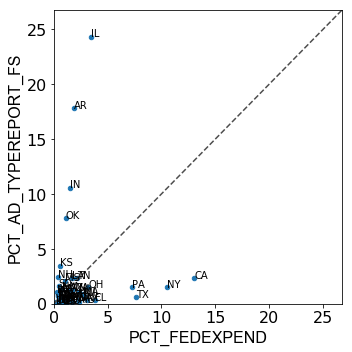

In [44]:
series1 = 'PCT_FEDEXPEND'
series2 = 'PCT_AD_TYPEREPORT_FS'

fig, axes = plt.subplots(figsize=(5, 5))
df_plot = pd.concat(
    [fs_series_dict[series1].rename(series1), fs_series_dict[series2].rename(series2)], 
    axis=1, sort=True
)
axes_max = max(max(fs_series_dict[series1]), max(fs_series_dict[series2]))
df_plot.dropna(inplace=True)
plot = df_plot.plot(
    x=series1, y=series2, kind='scatter', fontsize=16, ax=axes
)
for i, point in df_plot.iterrows():
    axes.text(point[series1], point[series2], str(i))
plot.set_xlabel(series1, fontsize=16, fontname='Arial')
plot.set_ylabel(series2, fontsize=16, fontname='Arial')
plot.set_ylim(bottom=0, top=1.1*axes_max)
plot.set_xlim(left=0, right=1.1*axes_max)
axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3")

plt.tight_layout()
plt.show()

In [48]:
df_plot.sort_values(series2, ascending=False)
state = 'IL'
len(df_financial[df_financial['STATE'] == state]['TOTFEDEXPEND_ADJUSTED'])
df_financial[df_financial['STATE'] == state]['TOTFEDEXPEND_ADJUSTED'].sum()
# df_financial[df_financial['STATE'] == state][
#     [
#         'AUDITYEAR','STATE','AUDITEENAME', 'EIN','TYPEOFENTITY','TOTFEDEXPEND',
#         'TYPEREPORT_SP_FRAMEWORK'
# #         'TYPEREPORT_FS'
#     ]
# ]
# df_financial[
#     (df_financial['STATE'] == state) & \
#     (df_financial['MATERIALWEAKNESS'] == 'Y')
# #     (df_financial['MATERIALNONCOMPLIANCE'] == 'Y')
# #     (df_financial['REPORTABLECONDITION'] == 'Y')
# #     (df_financial['TYPEREPORT_FS'].str.contains('A|D', regex=True))
# ]['TYPEOFENTITY'].value_counts()

863434128992.29797